In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np

In [2]:
from min_bisection import solution_schema

In [3]:
fldr = 'batch_12_14_20'

In [10]:
meta = pd.read_csv(os.path.join(fldr, 'summary_stats.csv'))

In [85]:
meta.head()

,solve_id,solve_type,n,p,q,cut_type,cut_value,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value
0,0,once,10,0.5,0.1,proportion,0.01,90,481,0.015625,0.0,0.015625,1.0
1,0,iterative,10,0.5,0.1,proportion,0.01,90,142,0.046875,0.0,0.046875,1.0
2,1,once,10,0.5,0.1,proportion,0.10,90,481,0.015625,0.0,0.015625,3.0
3,1,iterative,10,0.5,0.1,proportion,0.10,90,186,0.015625,0.0,0.015625,3.0
4,2,once,10,0.5,0.2,proportion,0.01,90,481,0.015625,0.0,0.015625,3.0


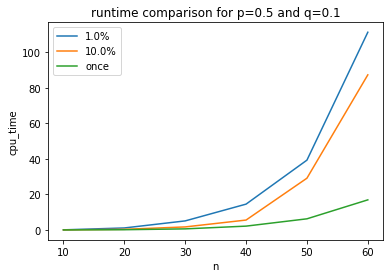

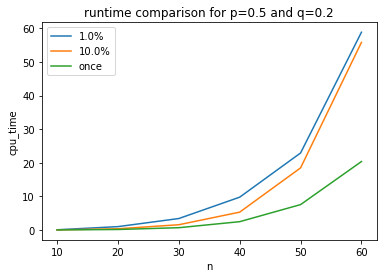

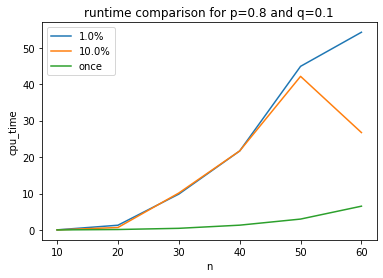

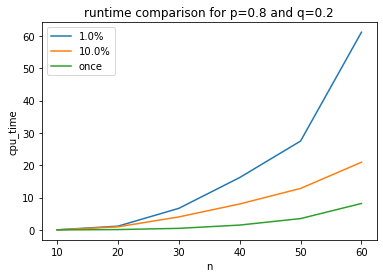

In [83]:
# average the runs
gd = meta.groupby(['p', 'q', 'solve_type', 'cut_type', 'cut_value', 'n'])['total_cpu_time'].mean().reset_index()

# get once solves down to single data points
once = gd[gd['solve_type'] == 'once']
once = once.groupby(['p', 'q', 'solve_type', 'n'])['total_cpu_time'].mean().reset_index()
gd = pd.concat([gd[gd['solve_type'] != 'once'], once])

# filter graph data by data set
filters = {'once' if pd.isnull(cut_value) else f'{100*cut_value}%' if cut_value < 1 else str(cut_value):
           (gd['cut_value'] == cut_value) | (pd.isnull(gd['cut_value']) & (pd.isnull(cut_value)))
           for cut_value in gd['cut_value'].unique() if pd.isnull(cut_value) or cut_value < 1}

# graph for each p, q combination 
for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
    for name, fltr in filters.items():
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr].sort_values('n')
        plt.plot(subset['n'], subset['total_cpu_time'], label=name)
        
    plt.title(f'runtime comparison for p={p} and q={q}')
    plt.ylabel('cpu_time')
    plt.xlabel('n')
    plt.legend()
    plt.show()

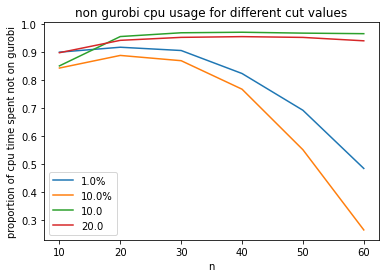

In [114]:
# graph showing ratio of non_gurobi_cpu_time to all total_cpu_time
gd = meta.groupby(['cut_value', 'n'])[['non_gurobi_cpu_time', 'total_cpu_time']].sum().reset_index()
gd['proportion_non_gurobi'] = gd['non_gurobi_cpu_time']/gd['total_cpu_time']
gd = gd.groupby(['cut_value'])[['n', 'proportion_non_gurobi']]
for cut_value, df in gd:
    plt.plot(df['n'], df['proportion_non_gurobi'], label=f'{100*cut_value}%' if cut_value < 1 else str(cut_value))
        
plt.title(f'non gurobi cpu usage for different cut values')
plt.ylabel('proportion of cpu time spent not on gurobi')
plt.xlabel('n')
plt.legend()
plt.show()